In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio
from scipy.interpolate import interp1d, interp2d

Load spreadsheets

In [2]:
def get_interp_datasheet_1D(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    if add_init:
        idx = np.insert(idx,0,add_init[0])
        arr = np.insert(arr,0,add_init[1])
    #return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value=(arr.ravel()[0], arr.ravel()[-1]))
    return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value='extrapolate')

def get_interp_datasheet_2D(file, sheet, skiprows, usecols, nrows):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return interp2d(idx1, idx2, arr)


Get interpolation functions

* **Note: Additional point added for $S_p$ of the 6MV beam for question 4D. In particular, when $r_d=0$ we have $S_p=1/1.078$. We use this to interpolate values between $r_d=0$ and $r_d=4$.**

In [3]:
# Arguments: rd, d
TMR_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV TMR', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1])
# Arguments: rd
Sp_int = get_interp_datasheet_1D('DATA1.xlsm', 'Linac outputs', skiprows=[28, 27],
                                     usecols=['C:L', 'C:L'], nrows=[1,1],
                                     add_init=[0,1/1.078])

# Arguments: rd
Sp250_int = get_interp_datasheet_1D('DATA1.xlsm', '250 kVp data', skiprows=[26, 24],
                                     usecols=['B:L', 'B:L'], nrows=[1,1])

# Question 1

Since 

* $SMR(d, r_d, E) = TMR(d,r_d,E)PSF(r^{(m)}_{d},E)-TMR(d,0,E)$
* $PSF(r^{(m)}_{d},E)= S_p(r^{(m)}_{d},E)PSF(r^{(m)}_0,E)$
* $TMR(d,0,E)=e^{-\mu(d-d_m)}$

where $(m)$ means at the position of maximum dose, and $r_d \approx r_d^{(m)}$, we get

$$SMR(d, r_d, E) = TMR(d,r_d,E)S_p(r_{d},E)PSF(r_0,E)-e^{-\mu(d-d_m)}$$




Get data:

In [4]:
d = np.array([5, 10, 20])
rd = np.array([5, 10, 30])
rd_mesh, d_mesh = np.meshgrid(rd, d)
#interpolate
TMRs = TMR_int(rd, d)
Sps = np.repeat(Sp_int(rd), 3).reshape(3,3).T
#data
mu = 0.043
PSF0 = 1.078
data = TMRs*Sps*PSF0-np.exp(-mu*(d_mesh-1.5))

Print table:

In [5]:
pd.DataFrame(data, columns=[f'SMR(d, {rdi}, 6MV)' for rdi in rd],
                   index=[f'd={di}' for di in d])

,"SMR(d, 5, 6MV)","SMR(d, 10, 6MV)","SMR(d, 30, 6MV)"
d=5,0.103496,0.140106,0.192050
d=10,0.095607,0.153458,0.238212
d=20,0.061527,0.122140,0.239060


**Comments**: Interestingly, while SMR decreases with depth for a field size of $5$cm, it actually increases in depth for a field size of $10$cm at $d=10$cm but then decreases at $d=20$cm. For a field size of $30$cm, the SMR increases throughout.

Mathematically, it is related to the relative rate of change between $TMR \cdot S_o \cdot PSF_0$ and $e^{-\mu(d-1.5)}$ as a function of depth $d$. $SMR$ can only increase as a function of depth if $TMR \cdot S_p \cdot PSF_0$ is decreasing slower than the $e^{-\mu(d-1.5)}$ primary beam attenuation term. Since $TMR$ is the only term that is a function of $d$, it requires that $TMR$ decrease slowly enough. This can only occur with sufficient phantom scatter, which is present in larger field sizes.

# Question 2

## Part A

Given the dimensions of the problem, it is reasonable that a rectangular, $8 \times 15$cm applicator should be used, since it it is the smallest applicator that covers the entire area.

## Part B

Read in the diagram

In [6]:
im = imageio.imread('a2diagram.png').sum(axis=-1)

Plot and place lines on the diagram. Red lines are used to calibrate units, blue lines give region of rectangle:

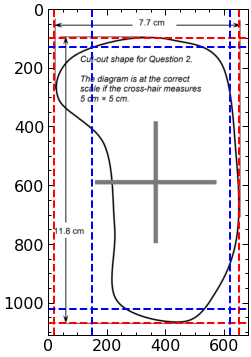

In [7]:
plt.imshow(im, cmap='gray')
plt.axvline(20, color='r', ls='--')
plt.axvline(650, color='r', ls='--')
plt.axhline(100, color='r', ls='--')
plt.axhline(1070, color='r', ls='--')
plt.axvline(150, color='b', ls='--')
plt.axvline(620, color='b', ls='--')
plt.axhline(130, color='b', ls='--')
plt.axhline(1020, color='b', ls='--')
plt.show()

The distance per unit is calculated from the red lines:

In [8]:
d = 11.8/(1070-100)

The area of the recangle is given by the blue lines

In [9]:
a = d*(620-150)
b = d*(1020-130)
print(f'a={a:.2f}')
print(f'b={b:.2f}')

a=5.72
b=10.83


The approximate equivalent square field is thus

In [10]:
rd = 2*a*b/(a+b)
rd

7.483232261976955

Or about $7.5 \times 7.5$cm.

## Part C

The attenuation coefficient is given by

$\mu = \rho \cdot (\mu/\rho)$

where $\rho=11.35$g/cm$^3$ and $\mu/\rho$ is interpolated from the table:

In [11]:
x1 = 2e-1
x2 = 3e-1
y1 = 9.985e-1
y2 = 4.035e-1
m = (y2-y1)/(x2-x1)
mu_rho = y1+m*(2.5e-1 - x1)
mu = mu_rho*11.35

Give that $I/I_0 = e^{-\mu x}$  we have

$$x = -\frac{1}{\mu} \cdot \ln(I/I_0) $$

In [12]:
x = -(1/mu)*np.log(0.03)
print(f'Thickness of Lead Required: {x:.3f}cm')

Thickness of Lead Required: 0.441cm


# Question 3

## Part A

The rate at which the dose is administered is given by

$$D' = D_0' S_c(r_c, E)S_p(r,E) = D_0'S_{c,p}(r_c,r_0,E) \cdot \frac{S_p(r)}{S_p(r_0)} $$

* $D_0'=61$cGy/min
* $r_c=6 \times 10$cm
* $r_0=7.5$cm (uniquely obtained from $r_c$)
* $r=6.5$cm (specified by lead cut-out)

The scatter factors are obtained from the 250kVp sheet. The time is then given by

$$t = D/D'$$

where $D=250$cGy

In [13]:
D = 250
D0p = 61.7
Scp = 0.957
Sp_r = Sp250_int([6.5])[0]
Sp_r0 = Sp250_int([7.5])[0]
Dp = D0p*Scp*Sp_r/Sp_r0
t = D/Dp
print(f'Time Required: {t:.2f}min')

Time Required: 4.31min


## Part B

We know that

$D(d) = D(0) \cdot P(r, d, E)$

where $P$ is percent depth dose. So we want to find $d$ such that

$P(6.5,d,E) = \frac{100}{250} = 0.4$

which, through trial and error in the excel spread sheet occurs at approximately $\boxed{d=8\text{cm}}$

## Part C

Since the field size at the surface and collimator setting are the same, we need only multiply by the inverse square factor to account for the SSD increasing

$$D' \to \left(\frac{SSD_0}{SSD}\right)^2 D'$$

In [14]:
SSD0 = 50
SSDnew = 52.5

Calculate new dose

In [15]:
Dpnew = Dp*(SSD0/SSDnew)**2
t = D / Dpnew
print(f'Time Required: {t:.2f}min')

Time Required: 4.75min


# Question 4

## Part A

Noting that 

$$SAR(d,r_d,E) = TMR(d,r_d,E)PSF(r_d,E) - TMR(d_m,0,E) = PSF(r_d,E) - 1$$

at $d=d_m$ (since $TMR(d_m,r_d,E)=1$), we need to compute $PSF$s for different values of $r_d$. These values are related to the three intersections we need to consider:

<p align="center">
  <img src="images/a2p2.png" alt="drawing" width="600" align="center"/>
</p>

It is clear that

* $R_1=3.5$cm
* $R_2=5.5$cm

$R_3$ can be calculated as follows. The height of point $A$ is $6.5/2 + 0.45$cm $=3.7$cm. This is the same as the height on the right triangle. Since $x/y$ is constant along the slope of the right triangle, the $x$ location along the triangle is $x_2 = 3.7 \cdot 6.3/4.8 =4.85625$cm or $6.3-4.85625 = 1.44375$cm from the right of the field. Thus $R_3 = 4.5 + 10.5 - 1.44375 = 13.55625$cm

* $R_3=13.55625$cm

**Computing PSF**:

Since $PSF(10,E)=1.078$ (lecture 3 page 34), the formula $PSF(r_d,E)=S_p(r_d,E)PSF(10,E)$ can be used to compute individual PSFs for $R_1$, $R_2$, and $R_3$. Note that $r_i = \sqrt{\pi}R_i$

In [16]:
r1 = np.sqrt(np.pi)*3.5
r2 = np.sqrt(np.pi)*5.5
r3 = np.sqrt(np.pi)*13.55625
print(r1)
print(r2)
print(r3)

6.203588478169306
9.748496179980338
24.0278275163379


These can be used to find the Sp's and thus the PSFs for each of the R's.

In [17]:
Sp1 = Sp_int([r1])[0]
Sp2 = Sp_int([r2])[0]
Sp3 = Sp_int([r3])[0]
PSF0 = 1.078
PSF1, PSF2, PSF3 = PSF0*np.array([Sp1,Sp2,Sp3])

The total PSF is given by

In [18]:
PSF = PSF1 - PSF2 + PSF3 
print(f'The PSF of segment 1 is {PSF:.3f}')

The PSF of segment 1 is 1.096


The SAR is given by

In [19]:
SAR = (PSF1-1)-(PSF2-1)+(PSF3-1)
print(f'The SAR of segment 1 is {SAR:.3f}')

The SAR of segment 1 is 0.096


## Part B

Since $PSF(r_d,E)=S_p(r_d,E)PSF(10,E)$, we are looking for the value of $r_d$ that makes $S_p = 1.069/1.078=0.99165$. From the interpolation sheet, this occurs precisely when $r_d = 7.3285$ 

The area of the unshaded regions is given by

In [20]:
A = 21*6.5 - 2*(0.5*4.8*6.3) - 2*6.5
A

93.26

This area is much larger than the area of the equivalent square:

In [21]:
7.3285**2

53.70691225

This discrepancy is due to the fact that Clarkson integration takes into account the effects of scatter: since the area of the unshaded regions is spread out throughout the image (blocked by shielding in various regions), less scatter contribution occurs than if the area were all confined to a single, fully-connected region. In addition, point A is located off the CAX and thus has less scatter contribution (which corresponds to a smaller equivalent square area).

## Part C

The following relationships hold

* $D_{P_A} = \frac{D_A}{PSF_A}$
* $D_{P_A} = 1.035D_{P_N}$
* $D_{P_N} =  \frac{D_N}{PSF_N} =\frac{D_N}{PSF(10)S_p(7.3285)} $

These relationships allow us to get $D_N$, which is proportional to the number of monitor units used

In [22]:
DA = 180
PSFA = 1.069
Sp = 0.99164975

DPA = DA/PSFA
DPN = DPA/1.031
DN = Sp*PSF0 *DPN

Since 1cGy/MU is delivered for $D_B$, the number of monitor units is:

In [23]:
print(f'The number of monitor units required is {DN:.2f}')

The number of monitor units required is 174.59


## Part D

Construct the image for Clarkson integration. Everything is scaled by a factor of 100

In [24]:
I = np.zeros((650,2100))
x = np.arange(0, 2100)
y = np.arange(0, 650)
xv,yv = np.meshgrid(x,y)
I[(xv>950)*(xv<1150)] = 1
I[yv<(480-480/630*xv)] = 2
I[yv<(480/630*(xv-(2100-630)))] = 2

origin = 100*np.array([10.5, 3.25])

Get the lines which we will use for Clarkson integration

In [25]:
thetas = np.linspace(80, -80, 9) *2*np.pi / 360
t = np.arange(0,3000,1)
xs = [origin[0] + t*np.cos(theta) for theta in thetas]
ys = [origin[1] + t*np.sin(theta) for theta in thetas]
for i, (xi, yi) in enumerate(zip(xs, ys)):
    mask = (xi<2100)*(xi>0)*(yi<650)*(yi>0)
    xs[i] = xi[mask]
    ys[i] = yi[mask]

Plot the image and lines:

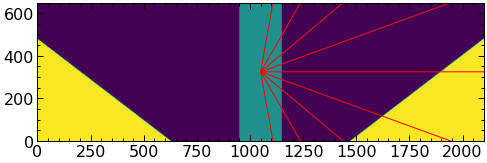

In [26]:
plt.imshow(I, origin='lower')
[plt.plot(x, y, color='r', lw=1) for x, y in zip(xs, ys)]
plt.xlim(0,2100)
plt.ylim(0,650)
plt.show()

Get interpolation of shielding

In [27]:
fI = interp2d(x, y, I)

Compute $R$ values needed for Clarkson integration

In [28]:
R1s = []
R2s = []
for xi, yi in zip(xs, ys):
    ls = np.array([fI(x, y) for (x, y) in zip(xi, yi)]).ravel().round().astype(int)
    R1 = sum(ls==1)
    R2 = R1 + sum(ls==0)
    R1s.append(R1)
    R2s.append(R2)
# unscale by the factor of 100 used
R1s = np.array(R1s)/100 
R2s = np.array(R2s)/100 
r1s = np.sqrt(np.pi)*R1s
r2s = np.sqrt(np.pi)*R2s

Compute mean value of $SAR$s. Note that we;ve only taken half the required lines in the diagram above, but because the shielding pattern is symmetric, the mean will be the same.

In [29]:
PSF1s = PSF0* np.array([Sp_int(r) for r in r1s])
PSF2s = PSF0* np.array([Sp_int(r) for r in r2s])
SARs = (PSF2s-1)-(PSF1s-1)
SARs = SARs.ravel()
SAR_mean = np.mean(SARs)
SAR_mean

0.03472165562746891

Now we know that

$$D_B = 0.03D_{P_m} + \text{Mean}(SAR) \cdot D_{P_m}$$

where the first term is the primary beam contribution and the second term is the scatter contribution

In [30]:
D = 0.03*DPN + SAR_mean*DPN
print(f'The dose administered is {D:.2f}cGy')

The dose administered is 10.57cGy


# Question 5

Before beginning, we will need to find $d_A$ and $d_C$ on the diagram below

<p align="center">
  <img src="images/a2p3.png" alt="drawing" width="600" align="center"/>
</p>

For $d_A$, note that

$$\tan(25^{\circ}) = \frac{4.5-d_A}{2.7}$$

Solving for $d_A$ yields

In [31]:
dA = 4.5-2.7*np.tan(25*2*np.pi/360)
dA

3.2409693229815035

For $d_C$, we have

$$\tan(25^{\circ}) = \frac{d_C-4.5}{2.7}$$

In [32]:
dC = 4.5+2.7*np.tan(25*2*np.pi/360)
dC

5.7590306770184965

## Part A

### Part (i)

This whole problem is made quite simple when noting that

$$D \propto TMR \cdot OAR \cdot S_p \cdot SPD^{-2}$$

* $TMR$ takes into account how much phantom is above the dose point (takes into account slanting surfaces at the top)
* $OAR$ takes into account the distance from the central axis (distance $x$ used is hoz distance between ray and isocenter)
* $S_p$ takes into account phantom scatter effects
* Inverse square law takes into account decreased beam intensity

This is summaried by the diagram:

<p align="center">
  <img src="images/a2p4.png" alt="drawing" width="600" align="center"/>
</p>

Furthermore, by definition, $TMR=OAR=1$ at $d_m$ along the CAX at the isocenter (dose point $D_N$).

Thus

$$D_i = D_N\cdot TMR(d_i, r_i) \cdot OAR(d_i,x_i)\frac{S_p(r_i)}{S_p(r_{d_N})}\left(\frac{SAD}{SSD_i+d_i}\right)^2$$

To obtain $D_N$, note that

$$\frac{D_E}{D_N} = TMR(d_E, r_{d_E}) \frac{S_p(r_{d_E})}{S_p(r_{d_N})}\left(\frac{SAD}{SAD+d_E}\right)^2$$

since the SSD is the SAD for $E$. 

In [33]:
dm = 1.5
SAD = 100
dE = 6+3+2
rdN = 12
rdE = 12*(SAD+dE)/SAD

These can be used to get TMRs and Sps (using interpolation function)

In [34]:
TMR = TMR_int(rdE,dE)[0]
Sp_rdE = Sp_int([rdE])[0]
Sp_rdN = Sp_int([rdN])[0]
print(f'TMR = {TMR:.2f}')
print(f'Sp_rdE = {Sp_rdE:.2f}')
print(f'Sp_rdN = {Sp_rdN:.2f}')

TMR = 0.77
Sp_rdE = 1.01
Sp_rdN = 1.01


Then DN can be obtained

In [35]:
DE = 100
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
DN

158.7937519284251

Now all the other quantities can be obtained to get the other doses (in order: A, B, C, D, F). For the off axis distances, we choose the coordinate system such that positive $x$ is towards the thick side of the wedge (to the left)

In [36]:
order = ['A', 'B', 'C', 'D', 'F']
ds = [dA,
      4.5,
      dC,
      dA+1.5+3+2,
      dC+1.5+3+2]
rds = 3*[12*(SAD+4.5)/SAD] + 2*[12*(SAD+dE)/SAD]
xs = np.array([2.7, 0, -2.7, 2.7, -2.7])
# Adjust xs so that they correspond to axial distance at isocenter
xs*= np.array([SAD/(SAD+4.5)]*3 + [SAD/(SAD+11)]*2)
SPDs = 3*[SAD+4.5] + 2*[SAD+dE]
[print(f'{o}: d={d:.2f}, rd={rd:.3f}, x={x:.2f}') \
     for (o, d, rd, x) in zip(order, ds, rds, xs)];

A: d=3.24, rd=12.540, x=2.58
B: d=4.50, rd=12.540, x=0.00
C: d=5.76, rd=12.540, x=-2.58
D: d=9.74, rd=13.320, x=2.43
F: d=12.26, rd=13.320, x=-2.43


These can be used to get TMRS and Sp's

In [37]:
TMRs = [TMR_int(rd,d)[0] for (rd,d) in zip(rds,ds)]
Sps = [Sp_int([rd])[0] for rd in rds]
OARs = [1.013, 1, 1.012, 1.009, 1.008]
[print(f'{o}: TMR={TMR:.5f}, Sp={Sp:.5f}, OAR={OAR:.5f}') \
     for (o, TMR, Sp, OAR) in zip(order, TMRs, Sps, OARs)];

A: TMR=0.97385, Sp=1.00660, OAR=1.01300
B: TMR=0.94379, Sp=1.00660, OAR=1.00000
C: TMR=0.91146, Sp=1.00660, OAR=1.01200
D: TMR=0.80734, Sp=1.00863, OAR=1.00900
F: TMR=0.73970, Sp=1.00863, OAR=1.00800


Then we can compute Doses

In [38]:
def compute_dose(DN, TMR, Sp, SPD, OAR):
    return DN*TMR*OAR*(Sp/Sp_rdN)*(SAD/SPD)**2

doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=143.65Gy
B: D=137.43Gy
C: D=134.32Gy
D: D=105.35Gy
F: D=96.42Gy


### Part (ii)

The only thing that changes here is the OARs

In [39]:
WOARs = [0.942, 1, 1.075, 0.946, 1.067]
doses = [compute_dose(DN, TMRi, Spi, SPDi, WOARi) \
         for (TMRi, Spi, SPDi, WOARi) in zip(TMRs, Sps, SPDs, WOARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=133.58Gy
B: D=137.43Gy
C: D=142.68Gy
D: D=98.77Gy
F: D=102.07Gy


Note that $F$ gets more dose, but this is because the beam is still prescribed to give 100Gy to point E (and since part of the wedge is in the way, it means the beam is either more intense/runs for longer).

## Part B

### Part (i)

Since $E$ recieves 100Gy, we first need to use this to find $D_N$, which we can eventually use to find all other doses.

Get effective distance to point E

In [40]:
rhos = np.array([1,0.4,1])
ds_E = np.array([6, 3, 2])
deff_E = np.dot(rhos, ds_E)
print(f'Effective Distance to E: {deff_E:.2f}')

Effective Distance to E: 9.20


Now point E is still prescribed to receive 100Gy; this can be used to recalculate $D_N$. We need the TMR that corresponds to the effective distance of $E$ above

In [41]:
DE = 100
TMR = TMR_int(rdE,dE)[0]
TMR_deff = TMR_int(rdE,deff_E)[0]
CF = TMR_deff/TMR
DN = DE/(CF*TMR* (Sp_rdE/Sp_rdN) * (SAD/(SAD+dE))**2)
print(f'DN={DN:.3f}Gy')

DN=149.487Gy


Now we can recompute the dose to the other points, provided we reevaluate the TMR values. The only TMRs that change are those for D and F. Lets bring back up the values of $r_d$ for all the different points (A,B,C,D,F):

In [42]:
print(rds)

[12.54, 12.54, 12.54, 13.32, 13.32]


These, along with the effective distances above to (D, E, F) and the actual distances to (A,C), can be used to calculate TMRs from our interpolation function `TMR_int`:

In [43]:
ds_D = np.array([dA+1.5, 3, 2])
ds_F = np.array([dC+1.5, 3, 2])
deffs = np.array([dA,4.5,dC] + [np.dot(rhos, ds) for ds in [ds_D, ds_F]])
TMRs = [TMR_int(rd,d)[0] for (rd,d) in zip(rds,deffs)]
print(TMRs)

[0.9738510041736863, 0.943794, 0.9114599037952583, 0.8557840734783568, 0.7880599374130225]


Now lets recompute all the doses:

In [44]:
OARs = [1.013, 1, 1.012, 1.009, 1.008]
doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=135.23Gy
B: D=129.38Gy
C: D=126.44Gy
D: D=105.12Gy
F: D=96.71Gy


### Part (ii)

The only thing that changes is the OARs, which are the same as in part A with the dynamic wedge:

In [45]:
WOARs = [0.942, 1, 1.075, 0.946, 1.067]
doses = [compute_dose(DN, TMRi, Spi, SPDi, WOARi) \
         for (TMRi, Spi, SPDi, WOARi) in zip(TMRs, Sps, SPDs, WOARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=125.75Gy
B: D=129.38Gy
C: D=134.31Gy
D: D=98.56Gy
F: D=102.37Gy


## Part C

**Without the homogeneity:**

TMR uses distance from surface to $E$ (sum of `ds_E` segments)

In [46]:
DE = 100
TMR = TMR_int(13.32, sum(ds_E))[0]
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
print(f'{DN:.2f} monitor units are required')

158.79 monitor units are required


**With the homogenity**

TMR uses effective distance from surface to $E$ (dot product of `ds_E` segments and `rhos` segment)

In [47]:
DE = 100
TMR = TMR_int(13.32, np.dot(rhos, ds_E))[0]
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
print(f'{DN:.2f} monitor units are required')

149.49 monitor units are required


# Question 6

## Part A

### No Wedge

We can write

$$\frac{D_E}{D_N} = TMR(d_E, r_{d_E})$$

where $D_E$ is the dose without inhomogenity. The dose received is $D_E^* = 100$cGy where

$$D_E^* = CF \cdot D_E = \left( \frac{TMR(3+2, r_{d_E})}{TMR(2, r_{d_E})} \right)^{0.4-1} D_E$$

Thus 

$$D_N = \frac{1}{CF \cdot TMR(d_E, r_{d_E})} D_E^* $$ 

where $r_{d_E}=12$ and $d_E=11$

In [48]:
DE_star = 100
TMR_E = TMR_int(12, 11)[0]
TMR_5 = TMR_int(12, 5)[0]
TMR_2 = TMR_int(12, 2)[0]
CF = (TMR_5/TMR_2)**(-0.6)
DN = 1/(CF*TMR_E) * DE_star

With $D_N$ we can compute the monitor units using

$$D_N' = \frac{D_N}{MU} = (1\text{cGy/MU})\cdot S_c(r_c) S_p(r_d) $$

In [49]:
Sc = 1.006
Sp = 1.005
MU_nw = DN/(Sc*Sp)
print(f'{MU_nw:.3f} monitor units are required')

123.671 monitor units are required


For the dose at point $D$ and $F$, we can invert the formula above for $D_N$ and add the OAR

$$D_X = OAR(d_X, r_{d_X})TMR(d_X, r_{d_X}) CF \cdot D_N $$ 

where $X=$ D or F.

In [50]:
dD = dA+1.5+3+2
dF = dC+1.5+3+2
print(dD, dF)

9.740969322981503 12.259030677018497


Thus, from interpolation, the TMRs OARs are

In [51]:
TMR_D = TMR_int(12, dD)[0]
TMR_F = TMR_int(12, dF)[0]
OAR_D = 1.011
OAR_F = 1.009

The corresponding doses are (`nw` means no wedge)

In [52]:
DD_nw = DN*TMR_D*OAR_D * CF
DF_nw = DN*TMR_F*OAR_F * CF

### With Wedge

With the wedge, $D_N$ is he same but the monitor units are different: we need to consider the wedge factor. 

$$D_N' = \frac{D_N}{MU} = (1\text{cGy/MU})\cdot S_c(r_c) S_p(r_d) WF $$

In [53]:
Sc = 1.006
Sp = 1.005
WF = 0.271
MU_w = DN/(Sc*Sp*WF)
print(f'{MU_w:.3f} monitor units are required')

456.350 monitor units are required


The off axis ratios also need to be adjusted

In [54]:
WOAR_D = 0.818
WOAR_F = 1.225

The corresponding doses are (`w` means wedge)

In [55]:
DD_w = DN*TMR_D*WOAR_D * CF
DF_w = DN*TMR_F*WOAR_F * CF

### The table

In [56]:
data = np.array([[100,100],[MU_nw,MU_w],[DD_nw,DD_w],[DF_nw, DF_w]])
pd.DataFrame(data, columns=['6MV No Wedge', '6MV, With Wedge'],
                   index=['Dose to E', 'MU', 'Dose to D', 'Dose to F'])

,6MV No Wedge,"6MV, With Wedge"
Dose to E,100.000000,100.000000
MU,123.670844,456.349977
Dose to D,105.651875,85.482922
Dose to F,96.371707,117.002320


## Part B

The aim here is to minimize the variance of the dose at points $D$, $E$, and $F$. We can expresss our doses as

$$D_D = fD_D^{(w)} + (1-f)D_D^{(nw)}$$
$$D_F = fD_F^{(w)} + (1-f)D_F^{(nw)}$$

where $f$ is the fraction of beam with the wedge, and $1-f$ is the fraction of beam without the wedge. The optimal value of $f$ is the one that minimizes the following **objective function** (the variance of the three doses):

$$\sum_{X} (D_X - \bar{D})^2$$

where $X$ specifies one of the dose points (D,E,F) and $\bar{D}=\sum_X D_x / N$ is the mean dose of the 3 locations ($N$ is number of dose points). This **objective function** above can actually be minimized **analytically** for an arbitrary number of dose points $D_X$ (see appendix), the solution is

$$f = \frac{\frac{1}{N}\left( \sum_X a_x \right)\left(\sum_X D_X^{(nw)} \right) - \sum_X a_X D_X^{(nw)}}{\sum_X a_XD_X^{(w)} - \sum_X a_XD_X^{(nw)} - \frac{1}{N}\left(\sum_X a_X\right)\left(\sum_X D_X^{(w)}\right) + \frac{1}{N}\left(\sum_X a_X\right)\left(\sum_X D_X^{(nw)}\right)} $$

where

$$a_X = D_X^{(w)} - D_X^{(nw)} - \frac{1}{N} \sum_Y \left(D_Y^{(w)} - D_Y^{(nw)}\right)$$

In [57]:
DX_nw = np.array([100, DD_nw, DF_nw])
DX_w = np.array([100, DD_w, DF_w])
nn = 1/3 #normalization for mean
ax = DX_w - DX_nw - nn*sum(DX_w-DX_nw)

f = (nn*sum(ax)*sum(DX_nw) - sum(ax*DX_nw)) \
/(sum(ax*DX_w) - sum(ax*DX_nw)-nn*sum(ax)*sum(DX_w)+nn*sum(ax)*sum(DX_nw))

print(f'Fraction of Beam on time with wedge: {f*100:.2f}%')
print(f'Fraction of Beam on time without wedge: {(1-f)*100:.2f}%')

Fraction of Beam on time with wedge: 22.73%
Fraction of Beam on time without wedge: 77.27%


The corresponding doses at the three locations are

In [58]:
Ds = f*DX_w + (1-f)*DX_nw
Ds

array([100.        , 101.0682635 , 101.06023529])

# Appendix

## Question 6

<p align="center">
  <img src="images/a2q6pb.jpg" alt="drawing" width="600" align="center"/>
</p>